# 1. Environment Setup

1.1. Checking what CPU/GPU you are connected to. Accessing GoogleDrive

In [ ]:
#Checking the GPU the notebook is connected to.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 18 16:15:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.2. Installation of Libraries

In [ ]:
#PyTorch + timm for easier access to pretrained CNNs and ViTs
#Lightning fabric/pytorch-lightning to remove bilerplate in the training loop
!pip install -q torch torchvision torchaudio torchmetrics timm lightning
!pip install -q grad-cam
import torch, torchvision, random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__, "| Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1.3. Dataset downloadn and sanity check.





In [ ]:
# Installation of libraries for data retreival
import os, zipfile, requests, tqdm, shutil

# Download the ZIP from Mendeley
zip_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/r6h24d2d3y-1.zip"  # direct file link
zip_path = "/content/Gallblader Diseases Dataset.zip"

if not os.path.exists(zip_path):
    with requests.get(zip_url, stream=True) as r, open(zip_path, "wb") as f:
        total = int(r.headers.get("content-length", 0))
        for chunk in tqdm.tqdm(r.iter_content(chunk_size=1<<20), total=total//(1<<20)):
            f.write(chunk)

# Unzip the main zip to /content/data/temp
data_root = "/content/data"
temp_extract_path = "/content/data/temp" # Temporal extraction path for the first zip
if os.path.exists(data_root): shutil.rmtree(data_root)
os.makedirs(data_root, exist_ok=True) # Ensure data_root exists
os.makedirs(temp_extract_path, exist_ok=True) # Ensure temp_extract_path exists


with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(temp_extract_path)

# Find and extract the inner zip files
# The inner zips are within a subdirectory inside temp_extract_path
inner_zip_dir = None
for root, dirs, files in os.walk(temp_extract_path):
    for d in dirs:
        # Assuming the directory containing the inner zips is the only one at this level
        # or has a recognizable name pattern
        inner_zip_dir = os.path.join(root, d)
        break # Assuming we found the directory containing the zips
    if inner_zip_dir:
        break # Found the directory, exit outer loop


if inner_zip_dir and os.path.exists(inner_zip_dir):
    print(f"Found inner zip directory: {inner_zip_dir}")
    for item in os.listdir(inner_zip_dir):
        item_path = os.path.join(inner_zip_dir, item)
        if item_path.endswith(".zip"):
            print(f"Extracting inner zip: {item_path}")
            try:
                with zipfile.ZipFile(item_path, 'r') as inner_zf:
                    # Extract contents of inner zips directly into data_root
                    inner_zf.extractall(data_root)
            except zipfile.BadZipFile:
                print(f"Skipping bad zip file: {item_path}")
else:
    print(f"Could not find inner zip directory within {temp_extract_path}")


# Clean up the temporary extraction directory
if os.path.exists(temp_extract_path): shutil.rmtree(temp_extract_path)
print("Extraction complete.")



1907it [01:45, 18.16it/s]                          


Found inner zip directory: /content/data/temp/Gallblader Diseases Dataset
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/2Abdomen and retroperitoneum.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/3cholecystitis.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/8Carcinoma.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/6Polyps and cholesterol crystals.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/5Perforation.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/1Gallstones.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/4Membranous and gangrenous cholecystitis.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/9Various causes of gallbladder wall thickening.zip
Extracting inner zip: /content/data/temp/Gallblader Diseases Dataset/7Adenomyomatosis.zip
Extraction complete.


In [ ]:
# Quick sanity-check
from collections import Counter
import glob, pandas as pd

image_paths = glob.glob(f"{data_root}/**/*.jpg", recursive=True)
labels = [p.split(os.sep)[-2] for p in image_paths]
class_counts = Counter(labels)
pd.DataFrame.from_dict(class_counts, orient='index', columns=['images']).sort_values('images')


,images
9Various causes of gallbladder wall thickening,990
6Polyps and cholesterol crystals,1020
5Perforation,1062
3cholecystitis,1146
7Adenomyomatosis,1164
2Abdomen and retroperitoneum,1170
4Membranous and gangrenous cholecystitis,1224
1Gallstones,1326
8Carcinoma,1590


# 2. Exploratory Data Analysis (EDA)


Top 10 image resolutions (w × h):


,width,height,count
0,1200,900,10639
3,900,1200,46
1,1170,876,5
2,2400,1800,2


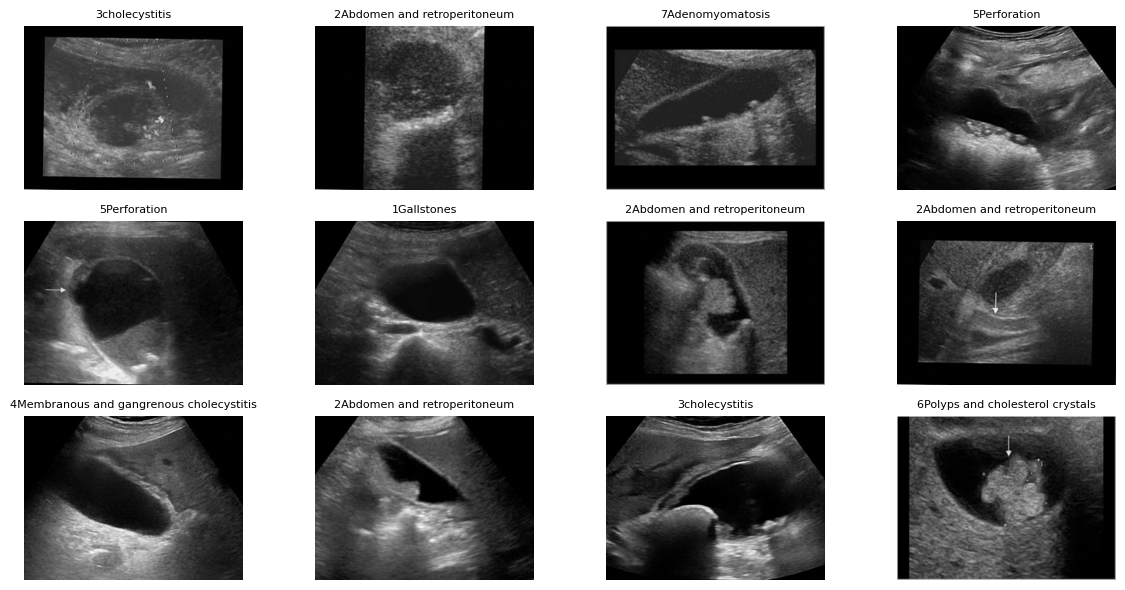

In [ ]:
# EDA
# Importing of Libraries needed
import matplotlib.pyplot as plt
from PIL import Image
import random, pandas as pd
from collections import Counter
from IPython.display import display

# Quick visual sanity‑check by randomly plotting images from each class.

def show_random_grid(n: int = 12):
    """Display an n‑image grid of randomly sampled ultrasound frames."""
    sample = random.sample(image_paths, n)
    plt.figure(figsize=(12, 6))
    for i, p in enumerate(sample):
        plt.subplot(3, 4, i + 1)
        plt.imshow(Image.open(p).convert("L"), cmap="gray")
        plt.title(p.split(os.sep)[-2], fontsize=8)
        plt.axis("off")
    plt.tight_layout()

show_random_grid()

# Review of Image resolution distribution
# Collect (width, height) for every image in the dataset
sizes = [Image.open(p).size for p in image_paths]  # (w, h)
size_counts = Counter(sizes)

# Tabulate the most frequent resolutions
resolution_df = pd.DataFrame(
    [{"width": w, "height": h, "count": c} for (w, h), c in size_counts.items()]
).sort_values("count", ascending=False)

print("\nTop 10 image resolutions (w × h):")
display(resolution_df.head(10))



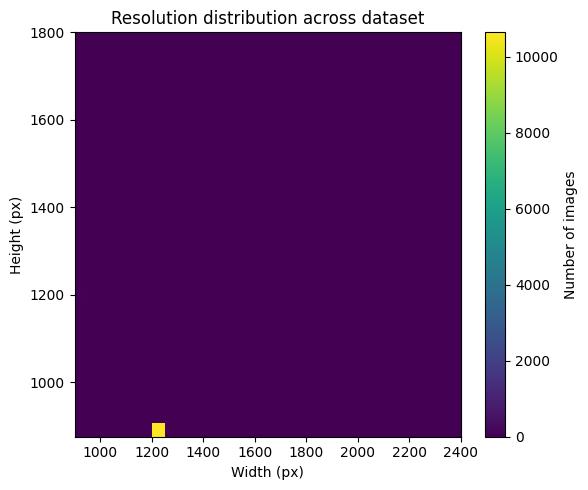

In [ ]:
# Creating a 2‑D histogram (heat‑map) of all widths vs heights
widths  = [w for (w, _) in sizes]
heights = [h for (_, h) in sizes]

plt.figure(figsize=(6, 5))
plt.hist2d(widths, heights, bins=[30, 30])
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Resolution distribution across dataset")
plt.colorbar(label="Number of images")
plt.tight_layout()
plt.show()

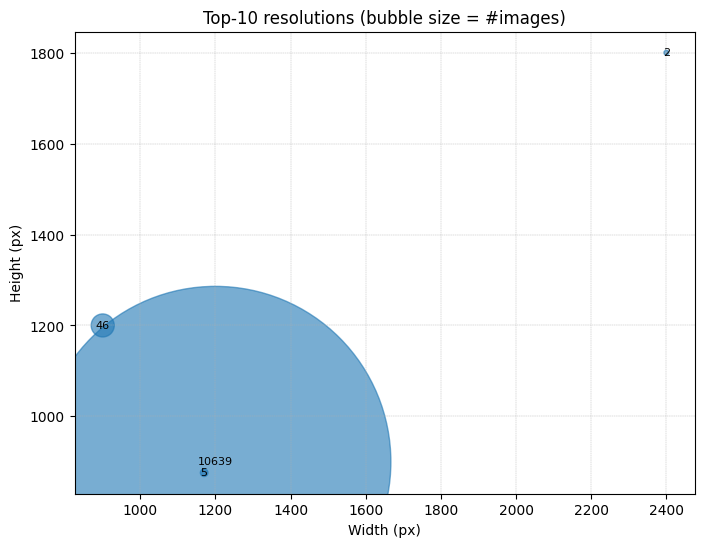

In [ ]:
# Creating a Bubble plot
top_n = 10

# Count (width, height) pairs and take the most common
pairs = Counter(sizes).most_common(top_n)
w_top  = [wh[0][0] for wh in pairs]    # widths
h_top  = [wh[0][1] for wh in pairs]    # heights
counts = [wh[1]     for wh in pairs]   # frequencies

plt.figure(figsize=(8,6))
plt.scatter(w_top, h_top, s=[c*6 for c in counts], alpha=0.6)  # bubble size / count
for w, h, c in zip(w_top, h_top, counts):
    plt.text(w, h, str(c), ha="center", va="center", fontsize=8)

plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title(f"Top-{top_n} resolutions (bubble size = #images)")
plt.grid(True, linestyle="--", linewidth=0.3)
plt.show()

In [ ]:
# Grayscale vs. Colour analysis
import textwrap
# Scanning of every image (or sample, if ~10 k feels slow)
scan_all = True        # flip to False to sample 2 000 files for speed
sample_size = 2_000

to_scan = image_paths if scan_all else random.sample(image_paths, sample_size)

mode_counter   = Counter()   # e.g. "L", "RGB", "RGBA"
pseudo_gray    = 0           # RGB triplets where all channels are equal
failed_reads   = 0

for p in tqdm.tqdm(to_scan, desc="Scanning images"):
    try:
        with Image.open(p) as im:
            mode_counter[im.mode] += 1
            # Check for 3-channel “gray masquerading as colour”
            if im.mode == "RGB":
                arr = np.asarray(im)
                if np.all(arr[..., 0] == arr[..., 1]) and np.all(arr[..., 1] == arr[..., 2]):
                    pseudo_gray += 1
    except Exception as e:
        failed_reads += 1

# Report Creation
total = len(to_scan)
print("\nImage mode counts:")
for m, c in mode_counter.most_common():
    print(f"  {m:<4} : {c}  ({100*c/total:.1f} %)")

if pseudo_gray:
    print(f"\n  From the {mode_counter['RGB']} RGB files, {pseudo_gray} "
          f"({100*pseudo_gray/max(1, mode_counter['RGB']):.1f} %) are pseudo-grayscale "
          "(all three channels identical).")

if failed_reads:
    print(f"\n{failed_reads} files could not be read.")

# Decision helper
msg = []
if mode_counter.get("RGB", 0) - pseudo_gray == 0 and mode_counter.get("RGBA", 0) == 0:
    msg.append("All images are effectively single-channel,thus you can safely convert to 1-channel tensors.")
else:
    msg.append("There are genuine colour images,hence converting to grayscale will lose information.")
    if pseudo_gray:
        msg.append("However, many RGBs are pseudo-grayscale, meaning  you could auto-detect and drop extra channels only for those.")

print("\n" + textwrap.fill(" ".join(msg), width=100))

Scanning images: 100%|██████████| 10692/10692 [01:29<00:00, 119.48it/s]


Image mode counts:
  RGB  : 10692  (100.0 %)

  From the 10692 RGB files, 6500 (60.8 %) are pseudo-grayscale (all three channels identical).

There are genuine colour images,hence converting to grayscale will lose information. However, many
RGBs are pseudo-grayscale, meaning  you could auto-detect and drop extra channels only for those.


Analysing: 100%|██████████| 10692/10692 [11:28<00:00, 15.53it/s]


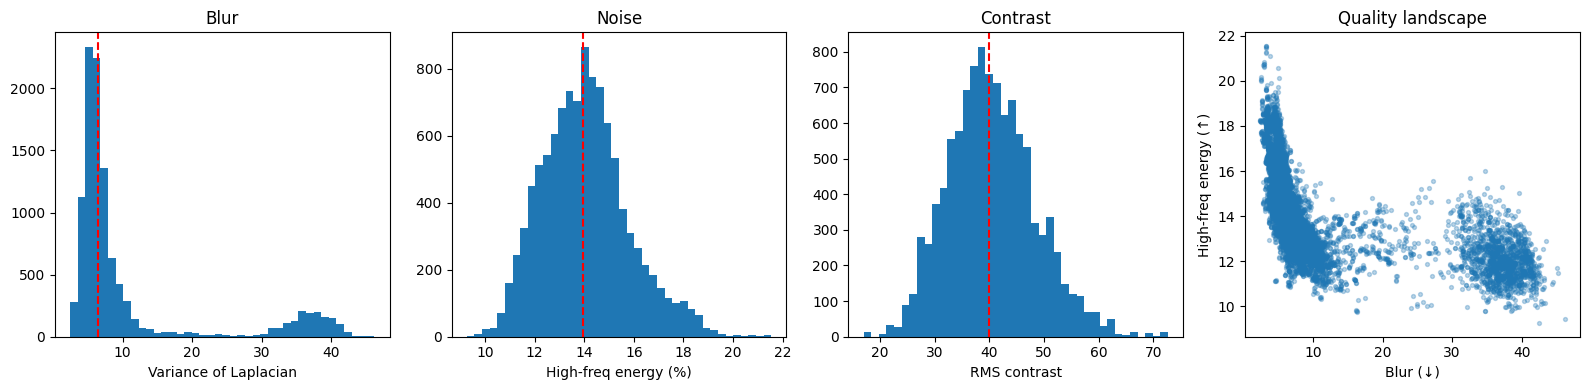

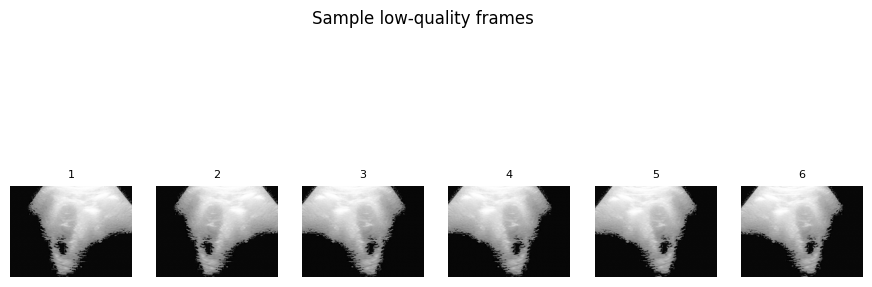

In [ ]:
# Artefact / Noise Analysis
# Importing additionally needed libraries
import cv2
from PIL import ImageOps

def analyse_one(path):
    """Returns blur_var, hp_energy, contrast for a single image."""
    im  = Image.open(path).convert("L")
    arr = np.asarray(im, dtype=np.float32)

    # Blur: variance of Laplacian
    blur_var = cv2.Laplacian(arr, cv2.CV_32F).var()

    # High-frequency energy: proportion of FFT power outside centre
    f  = np.fft.fftshift(np.fft.fft2(arr))
    mag = np.abs(f)
    h, w = mag.shape
    centre = mag[h//4:3*h//4, w//4:3*w//4]
    hp_energy = 100 * (mag.sum() - centre.sum()) / mag.sum()

    # RMS contrast
    contrast = arr.std()
    return blur_var, hp_energy, contrast

# Scan
scan_lim   = None          # None = scan all, or set an int (e.g. 3000) to sample for speed
paths_scan = image_paths if scan_lim is None else random.sample(image_paths, scan_lim)

records = []
for p in tqdm.tqdm(paths_scan, desc="Analysing"):
    records.append((p, *analyse_one(p)))

df_qc = pd.DataFrame(records, columns=["path", "blur_var", "hp_energy", "contrast"])

# Visualising the results in Plots
plt.figure(figsize=(16,4))

# 1. Blur
plt.subplot(1,4,1)
plt.hist(df_qc.blur_var, bins=40)
plt.xlabel("Variance of Laplacian"); plt.title("Blur")
plt.axvline(df_qc.blur_var.median(), color="r", linestyle="--")

# 2. High-freq energy
plt.subplot(1,4,2)
plt.hist(df_qc.hp_energy, bins=40)
plt.xlabel("High-freq energy (%)"); plt.title("Noise")
plt.axvline(df_qc.hp_energy.median(), color="r", linestyle="--")

# 3. Contrast
plt.subplot(1,4,3)
plt.hist(df_qc.contrast, bins=40)
plt.xlabel("RMS contrast"); plt.title("Contrast")
plt.axvline(df_qc.contrast.median(), color="r", linestyle="--")

# 4. Blur vs. noise scatter plot
plt.subplot(1,4,4)
plt.scatter(df_qc.blur_var, df_qc.hp_energy, alpha=0.3, s=8)
plt.xlabel("Blur (↓)"); plt.ylabel("High-freq energy (↑)")
plt.title("Quality landscape")

plt.tight_layout(); plt.show()

# Show worst offenders
n_show = 6
worst = (df_qc.blur_var < df_qc.blur_var.quantile(0.05)) | (df_qc.hp_energy > df_qc.hp_energy.quantile(0.95))
bad_paths = df_qc[worst].sort_values(["blur_var", "hp_energy"]).head(n_show).path.tolist()

plt.figure(figsize=(11,4))
for i, p in enumerate(bad_paths):
    plt.subplot(1, n_show, i+1)
    plt.imshow(ImageOps.equalize(Image.open(p).convert("L")), cmap="gray")
    plt.title(f"{i+1}", fontsize=8); plt.axis("off")
plt.suptitle("Sample low-quality frames", y=1.05)
plt.show()


# 3. Data Pre-processing and preparation.

3.1. Setting up of QC Threshold to filter out images with unstatisfying quality.

In [ ]:
# QC thresholds
MIN_BLUR, MAX_NOISE, MIN_CONTR = 5, 22, 25

ban_mask = (
    (df_qc.blur_var < MIN_BLUR) |
    (df_qc.hp_energy > MAX_NOISE) |
    (df_qc.contrast  < MIN_CONTR)
)
approved = df_qc[~ban_mask].path.tolist()
print(f"Approved images: {len(approved)} / {len(df_qc)}")


Approved images: 8548 / 10692


3.2. Dataset class with per-image repairs (CLAHE + denoise when needed).

In [ ]:
# Helpers
import cv2, numpy as np
from PIL import Image
def apply_clahe(arr):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(arr.astype(np.uint8))
def denoise(arr):
    return cv2.fastNlMeansDenoising(arr.astype(np.uint8), h=10)

# Custom Dataset
from torch.utils.data import Dataset
class UltrasoundDS(Dataset):
    def __init__(self, paths, tfms, qc_df):
        self.paths, self.tfms = paths, tfms
        self.qc = qc_df.set_index("path")
        self.cls2idx = {c:i for i,c in enumerate(sorted(set(labels)))}

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p   = self.paths[idx]
        arr = np.asarray(Image.open(p).convert("L"))

        # on-the-fly corrections
        row = self.qc.loc[p]
        if row.contrast < 30:
            arr = apply_clahe(arr)
        if row.hp_energy > 18:
            arr = denoise(arr)

        x = self.tfms(Image.fromarray(arr))
        y = self.cls2idx[p.split(os.sep)[-2]]
        return x, y


3.3. Augmentation & three-way loaders (75 / 15 / 10, single-channel).

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import torch, numpy as np

# Transforms
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# 75 / 15 / 10 split
train_p, temp_p = train_test_split(
    approved, test_size=0.25,          # 75 % train, 25 % temp
    stratify=[p.split(os.sep)[-2] for p in approved],
    random_state=SEED
)
val_p, test_p = train_test_split(
    temp_p, test_size=0.40,            # 40 % of 25 %  => 10 % overall
    stratify=[p.split(os.sep)[-2] for p in temp_p],
    random_state=SEED
)

print(f"train {len(train_p)}  val {len(val_p)}  test {len(test_p)}")

# Datasets
train_ds = UltrasoundDS(train_p, train_tfms, df_qc)
val_ds   = UltrasoundDS(val_p,   val_tfms,   df_qc)
test_ds  = UltrasoundDS(test_p,  val_tfms,   df_qc)   # no augmentations

# Sampler & loaders
freqs = Counter([p.split(os.sep)[-2] for p in train_p])
weights = torch.tensor([1/freqs[c] for c in sorted(freqs.keys())], dtype=torch.float)
sample_w = [weights[train_ds.cls2idx[p.split(os.sep)[-2]]] for p in train_p]
sampler  = WeightedRandomSampler(sample_w, len(sample_w), replacement=True)

train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


train 6411  val 1282  test 855


# 4. Baseline and Main Model Training.

4.1. Model Factory

In [ ]:
# MODEL FACTORY
!pip install -q timm

import timm, torch, torch.nn as nn, copy, time
import torch.optim as optim
from torchmetrics.classification import MulticlassRecall
from torch.cuda.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

def make_model(name: str,
               in_chans: int = 1,
               n_classes: int = 9,
               drop_rate: float = 0.2,
               drop_path: float = 0.2) -> nn.Module:
    """
    Returns a timm vision model ready for single-channel inputs.
    """
    model = timm.create_model(
        name,
        pretrained=True,
        in_chans=in_chans,
        num_classes=n_classes,
        drop_rate=drop_rate,          # classifier dropout
        drop_path_rate=drop_path      # stochastic depth
    )
    return model.to(device)


4.2. Training Loop for the two models.

In [ ]:
def train_finetune(model_name="efficientnet_b0",
                   head_lr=3e-3, ft_lr=1e-4,
                   head_epochs=2, ft_epochs=30,
                   patience=3, drop_rate=0.2, drop_path=0.2):

    model = make_model(model_name, drop_rate=drop_rate, drop_path=drop_path)
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))

    #Containers to log each epoch
    hist = {
        "epoch":    [],
        "phase":    [],          # "head" or "ft"
        "train_loss": [], "val_loss": [],
        "train_rec":  [], "val_rec":  []
    }

    # STAGE 1 (head frozen)
    for n,p in model.named_parameters():
        if "classifier" not in n and "fc" not in n:
            p.requires_grad = False
    opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=head_lr, weight_decay=1e-4)
    scaler = GradScaler()
    recall = MulticlassRecall(num_classes=9, average="macro").to(device)

    def run_epoch(train: bool):
        loader = train_dl if train else val_dl
        model.train() if train else model.eval()
        recall.reset(); epoch_loss = 0.
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            with autocast():
                preds = model(xb)
                loss  = criterion(preds, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            epoch_loss += loss.item()*xb.size(0)
            recall.update(preds, yb)
        return epoch_loss/len(loader.dataset), recall.compute().item()

    for ep in range(1, head_epochs+1):
        tr_loss, tr_rec = run_epoch(True)
        val_loss, val_rec = run_epoch(False)
        print(f"[HEAD] Ep{ep:02d}  trainR={tr_rec:.3f}  valR={val_rec:.3f}")

        #log
        hist["epoch"].append(ep); hist["phase"].append("head")
        hist["train_loss"].append(tr_loss); hist["val_loss"].append(val_loss)
        hist["train_rec"].append(tr_rec);   hist["val_rec"].append(val_rec)

    # STAGE 2 (full fine-tune)
    for p in model.parameters(): p.requires_grad = True
    opt   = optim.AdamW(model.parameters(), lr=ft_lr, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=ft_epochs)

    best_rec, bad, best_state = 0., 0, None
    for ep in range(1, ft_epochs+1):
        tr_loss, tr_rec = run_epoch(True)
        val_loss, val_rec = run_epoch(False)
        sched.step()

        hist["epoch"].append(head_epochs+ep); hist["phase"].append("ft")
        hist["train_loss"].append(tr_loss);   hist["val_loss"].append(val_loss)
        hist["train_rec"].append(tr_rec);     hist["val_rec"].append(val_rec)

        good = val_rec > best_rec + 1e-4
        if good:
            best_rec, bad = val_rec, 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            bad += 1
        print(f"[FT ] Ep{ep:02d}  trainR={tr_rec:.3f}  valR={val_rec:.3f} "
              f"{'**BEST**' if good else ''}")
        if bad >= patience:
            print("Early stopping triggered."); break

    model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"{model_name}_best.pt")
    print(f"Best val macro-recall: {best_rec:.3f}")
    return model, best_rec, hist        #return history dict


4.3. Plotting Helpers of Train Validation Results.

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["train_loss"], label="train loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curve")
    plt.legend(); plt.grid(True); plt.show()

def plot_recall(history):
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["train_rec"], label="train recall")
    plt.plot(history["epoch"], history["val_rec"],   label="val recall")
    plt.xlabel("epoch"); plt.ylabel("macro-recall"); plt.title("Recall curve")
    plt.legend(); plt.grid(True); plt.show()


4.4. Training of Models and Generating the Plots to compare the training process.

<ipython-input-23-d3825b1e88f1>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-d3825b1e88f1>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[HEAD] Ep01  trainR=0.239  valR=0.359
[HEAD] Ep02  trainR=0.345  valR=0.457
[FT ] Ep01  trainR=0.561  valR=0.791 **BEST**
[FT ] Ep02  trainR=0.798  valR=0.917 **BEST**
[FT ] Ep03  trainR=0.895  valR=0.968 **BEST**
[FT ] Ep04  trainR=0.945  valR=0.978 **BEST**
[FT ] Ep05  trainR=0.962  valR=0.984 **BEST**
[FT ] Ep06  trainR=0.971  valR=0.990 **BEST**
[FT ] Ep07  trainR=0.979  valR=0.993 **BEST**
[FT ] Ep08  trainR=0.985  valR=0.992 
[FT ] Ep09  trainR=0.988  valR=0.991 
[FT ] Ep10  trainR=0.991  valR=0.994 **BEST**
[FT ] Ep11  trainR=0.992  valR=0.994 
[FT ] Ep12  trainR=0.993  valR=0.995 **BEST**
[FT ] Ep13  trainR=0.994  valR=0.995 **BEST**
[FT ] Ep14  trainR=0.994  valR=0.995 
[FT ] Ep15  trainR=0.995  valR=0.994 
[FT ] Ep16  trainR=0.996  valR=0.994 
Early stopping triggered.
Best val macro-recall: 0.995


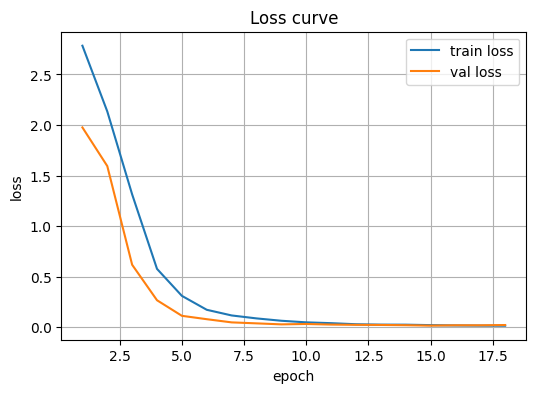

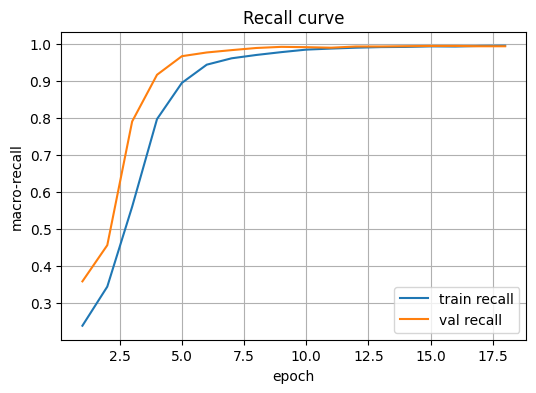

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

[HEAD] Ep01  trainR=0.196  valR=0.327
[HEAD] Ep02  trainR=0.284  valR=0.426
[FT ] Ep01  trainR=0.467  valR=0.768 **BEST**
[FT ] Ep02  trainR=0.730  valR=0.914 **BEST**
[FT ] Ep03  trainR=0.866  valR=0.979 **BEST**
[FT ] Ep04  trainR=0.930  valR=0.990 **BEST**
[FT ] Ep05  trainR=0.953  valR=0.994 **BEST**
[FT ] Ep06  trainR=0.969  valR=0.996 **BEST**
[FT ] Ep07  trainR=0.980  valR=0.996 
[FT ] Ep08  trainR=0.984  valR=0.997 **BEST**
[FT ] Ep09  trainR=0.987  valR=0.997 
[FT ] Ep10  trainR=0.991  valR=0.997 
[FT ] Ep11  trainR=0.992  valR=0.996 
Early stopping triggered.
Best val macro-recall: 0.997


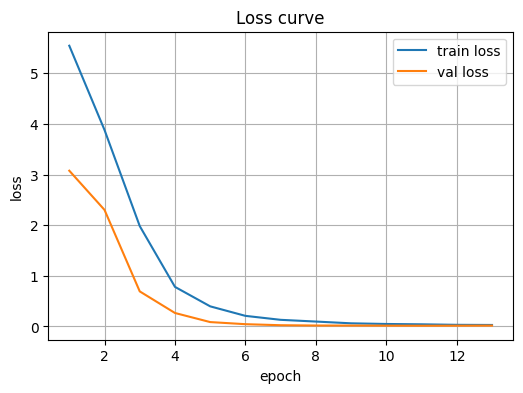

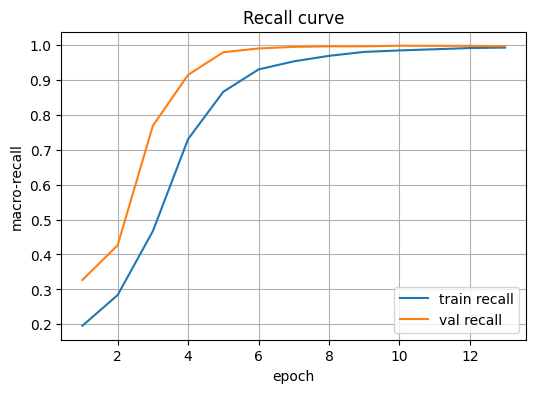

In [ ]:
# baseline model training - efficientnet_b0
base_model, base_best, base_hist = train_finetune("efficientnet_b0", ft_epochs=30)

plot_loss(base_hist)
plot_recall(base_hist)

# main model training - tf_efficientnetv2_s
main_model, main_best, main_hist = train_finetune("tf_efficientnetv2_s", ft_epochs=30,
                                                  drop_rate=0.25, drop_path=0.2)


plot_loss(main_hist)
plot_recall(main_hist)


# 5. Evaluation and Testing

5.1.  Defining Utility functions for macro recall, confusion matrix plot, per class recall plot.

In [ ]:
#Import of libraries and packages
from torchmetrics.classification import MulticlassRecall
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#Defining the macro recall method to compute the average recall on classes.
def evaluate_macro_recall(model, loader):
    model.eval()
    recall = MulticlassRecall(num_classes=9, average="macro").to(device)
    with torch.no_grad():
        for xb, yb in loader:
            recall.update(model(xb.to(device)), yb.to(device))
    return recall.compute().item()

#Defining the plotting method for the confusion matrix
def plot_confusion(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            ys.extend(yb.numpy())
            ps.extend(model(xb.to(device)).argmax(1).cpu().numpy())
    cm = confusion_matrix(ys, ps)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Test confusion matrix")
    plt.show()
    return cm

#Defining the plotting method for the per class recall comparison results.
def plot_per_class_recall(model, loader, class_names, wrap=18, palette_name="husl"):

    # gather preds / targets
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            ys.extend(yb.cpu().numpy())
            ps.extend(model(xb.to(device)).argmax(1).cpu().numpy())

    recalls = []
    for c in range(len(class_names)):
        tp = np.sum((np.array(ps)==c) & (np.array(ys)==c))
        fn = np.sum((np.array(ps)!=c) & (np.array(ys)==c))
        recalls.append(tp / (tp+fn+1e-9))

    # tidy labels
    tidy = []
    for lbl in class_names:
        idx   = "".join(ch for ch in lbl if ch.isdigit())
        text  = lbl[len(idx):].strip()
        tidy.append(f"{idx}\n{textwrap.fill(text, wrap)}")

    # colour palette
    colours = sns.color_palette(palette_name, n_colors=len(class_names))

    # plot
    plt.figure(figsize=(12, 5))
    sns.barplot(x=tidy,
                y=recalls,
                hue=tidy,                # use label itself as hue
                palette=colours,
                dodge=False,
                legend=False)            # hide redundant legend
    plt.ylim(0, 1.05)
    plt.ylabel("Recall")
    plt.title("Per-class recall (test)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()


5.2. Evaluation of macro recall and plotting the confusion matrix.

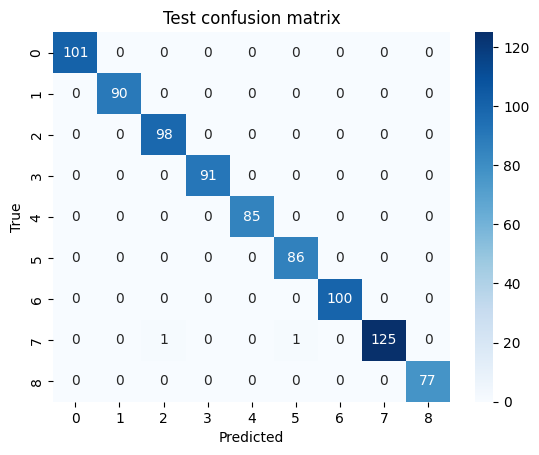

In [ ]:
test_recall = evaluate_macro_recall(main_model, test_dl)
conf_mat    = plot_confusion(main_model, test_dl)


5.3. Plotting the Per Class Recall Results.

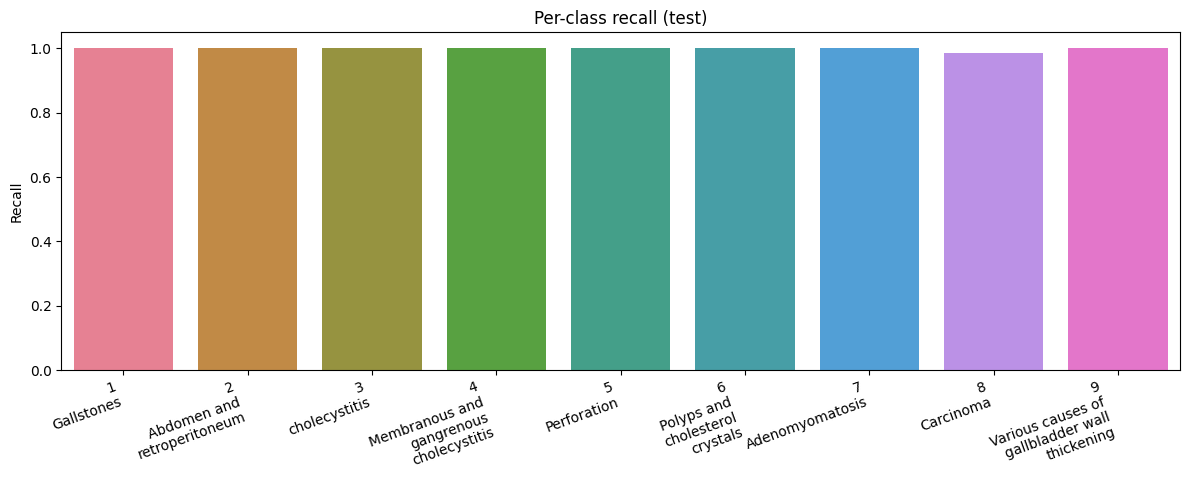

In [ ]:
plot_per_class_recall(main_model, test_dl, class_names)



5.4. Saving the models to the Gdrive.

In [ ]:
!cp tf_efficientnetv2_s_best.pt /content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/


In [ ]:
!cp efficientnet_b0_best.pt /content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/

5.5. Creating a helper for prediction tests.

In [ ]:
# Loading of needed libraries
from PIL import Image
import torch, torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Load the best checkpoint
ckpt = "/content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/tf_efficientnetv2_s_best.pt"
model = make_model("tf_efficientnetv2_s")          # factory defined earlier
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()

# Inference transform (same as val_tfms)
infer_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Helper: predict *and* plot
def predict_and_show(img_path):
    #Returns soft-max vector and plots the frame with top-1 prediction.
    img = Image.open(img_path).convert("L")
    tensor = infer_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        probs = F.softmax(model(tensor), dim=1).cpu().numpy()[0]

    top_idx  = probs.argmax()
    top_prob = probs[top_idx] * 100        # to %

    # console print
    print(f"Predicted class : {class_names[top_idx]}")
    print(f"Confidence      : {top_prob:.2f} %")

    # display
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.title(f"{class_names[top_idx]}  ({top_prob:.2f}%)")
    plt.axis("off")
    plt.show()

    return probs




5.6. Demo prediction on three random images downloaded from Google.

Predicted class : 1Gallstones
Confidence      : 93.73 %


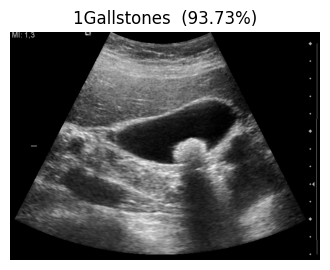

Predicted class : 5Perforation
Confidence      : 100.00 %


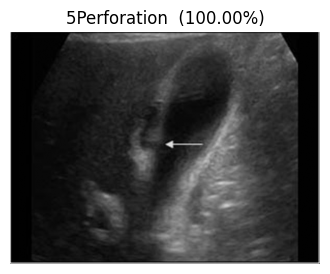

Predicted class : 8Carcinoma
Confidence      : 99.57 %


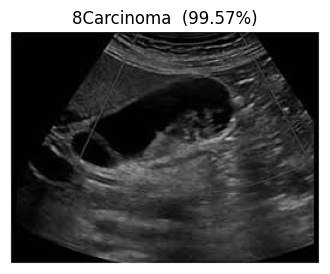

array([2.6682843e-04, 3.7672161e-03, 3.7855363e-05, 5.0057626e-08,
       1.7352891e-04, 6.1916376e-07, 1.3030528e-05, 9.9571770e-01,
       2.3172033e-05], dtype=float32)

In [ ]:
# Demo on three images
img_path1 = "/content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/test1.jpg" #Should be Gallstones
img_path2 = "/content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/test2.jpg" #Should be Gallbladder Perforation
img_path3 = "/content/drive/MyDrive/AI/AIN7301_Gallbladder_Model/test3.jpg" #Should be Gallbladder Carcinoma

predict_and_show(img_path1)
predict_and_show(img_path2)
predict_and_show(img_path3)